##XGBoosting

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from __future__ import print_function
import os

from google.colab import drive
drive.mount('/content/drive')

filepath = '/content/drive/My Drive/Colab Notebooks/Dataset/Walmart.csv'
xg = pd.read_csv(filepath)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
xg.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [ ]:
xg.shape

(6435, 8)

In [ ]:
xg.dtypes.value_counts()

float64    5
int64      2
object     1
dtype: int64

In [ ]:
xg = xg.drop('Date',axis=1)

In [ ]:
float_columns = (xg.dtypes == np.float)
print( (xg.loc[:,float_columns].max()==1.0).all() )
print( (xg.loc[:,float_columns].min()==-1.0).all() )

False
False


<ipython-input-7-c6b27d4c13c4>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  float_columns = (xg.dtypes == np.float)


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

xg['Holiday_Flag'] = le.fit_transform(xg['Holiday_Flag'])

le.classes_

array([0, 1])

In [ ]:
xg.Holiday_Flag.unique()

array([0, 1])

In [ ]:
from sklearn.model_selection import train_test_split

feature_columns = [x for x in xg.columns if x != 'Holiday_Flag']

X_train, X_test, y_train, y_test = train_test_split(xg[feature_columns], xg['Holiday_Flag'],
                 test_size=0.3, random_state=42)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4504, 6), (4504,), (1931, 6), (1931,))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

error_list = list()

tree_list = [15, 50, 100, 200, 400]
for n_trees in tree_list:

    GBC = GradientBoostingClassifier(n_estimators=n_trees,
                                     subsample=0.5,
                                     max_features=4,
                                     random_state=42)

    GBC.fit(X_train.values, y_train.values)
    y_pred = GBC.predict(X_test)

    error = 1. - accuracy_score(y_test, y_pred)

    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

error_xg = pd.concat(error_list, axis=1).T.set_index('n_trees')

error_xg

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


,error
n_trees,
15.0,0.073019
50.0,0.069912
100.0,0.069394
200.0,0.064215
400.0,0.050751


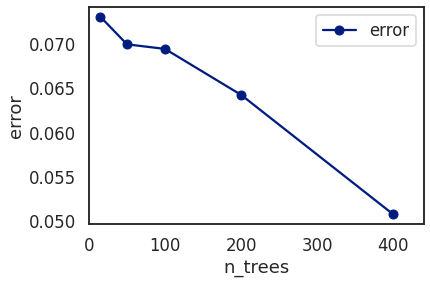

In [ ]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

ax = error_xg.plot(marker='o')

ax.set(xlabel='n_trees', ylabel='error')
ax.set_xlim(0, max(error_xg.index)*1.1);

Number of trees vs error graph

In [ ]:
param_grid = {'n_estimators': [200, 400],
              'learning_rate': [0.1, 0.01]}

GV_GBC = GridSearchCV(GradientBoostingClassifier(subsample=0.5,
                                                 max_features=4,
                                                 random_state=42),
                      param_grid=param_grid,
                      scoring='accuracy',
                      n_jobs=-1)

GV_GBC = GV_GBC.fit(X_train, y_train)

In [ ]:
GV_GBC.best_estimator_

GradientBoostingClassifier(max_features=4, n_estimators=400, random_state=42,
                           subsample=0.5)

##Accuracy, Classification Report, ROC AUC Score, Confusion Matrix for XGBoosting

In [ ]:
from sklearn.metrics import classification_report

y_pred = GV_GBC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1880
           1       0.33      0.92      0.49        51

    accuracy                           0.95      1931
   macro avg       0.67      0.94      0.73      1931
weighted avg       0.98      0.95      0.96      1931



- Based from the classification report, the team got an accuracy of 0.95 and with 1.00, 0.95 and 0.97 for precision, recall and f1-score, respectively.

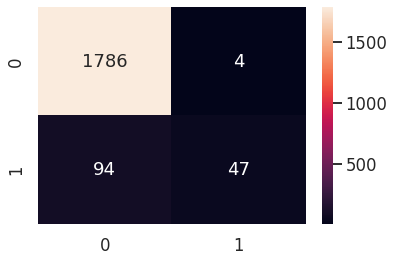

In [ ]:
from sklearn.metrics import confusion_matrix

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
from scipy.stats import uniform, randint
import xgboost as xgb
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_auc_score

In [ ]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", voting='hard', random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print(confusion_matrix(y_test, y_pred))

[[1789    1]
 [ 130   11]]


In [ ]:
y_pred = xgb_model.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1919
           1       0.08      0.92      0.14        12

    accuracy                           0.93      1931
   macro avg       0.54      0.92      0.55      1931
weighted avg       0.99      0.93      0.96      1931



In [ ]:
print(accuracy_score(y_test, y_pred))

0.9321595028482651


In [ ]:
print(roc_auc_score(y_pred,y_test))

0.9244615250998783


After importing the xgboost as xgb and applying the code above, the classification report has slightly changed as well as as the accuracy. It has reduced to 0.93 now which is still a good value and the team got 0.924 as the roc auc score as well.

##Agglomerative Clustering

In [ ]:
from sklearn.cluster import KMeans

float_columns = [x for x in xg.columns if x not in ['Holiday_Flag', 'Unemployment']]

km = KMeans(n_clusters=2, random_state=42)
km = km.fit(xg[float_columns])

xg['kmeans'] = km.predict(xg[float_columns])

In [ ]:
km_list = list()

for clust in range(1,21):
    km = KMeans(n_clusters=clust, random_state=42)
    km = km.fit(xg[float_columns])

    km_list.append(pd.Series({'clusters': clust,
                              'inertia': km.inertia_,
                              'model': km}))

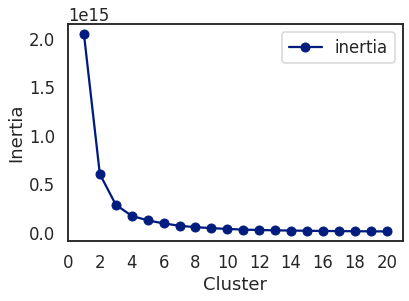

In [ ]:
plot_xg = (pd.concat(km_list, axis=1)
             .T
             [['clusters','inertia']]
             .set_index('clusters'))

ax = plot_xg.plot(marker='o',ls='-')
ax.set_xticks(range(0,21,2))
ax.set_xlim(0,21)
ax.set(xlabel='Cluster', ylabel='Inertia');

Inertia vs. Cluster graph

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from matplotlib import colors

ag = AgglomerativeClustering(n_clusters=2, linkage='ward', compute_full_tree=True)
ag = ag.fit(xg[float_columns])
xg['agglom'] = ag.fit_predict(xg[float_columns])

In [ ]:
(xg[['Holiday_Flag','agglom','kmeans']]
 .groupby(['Holiday_Flag','agglom','kmeans'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))

number
Holiday_Flag agglom kmeans        
0            0      0         1384
                    1         2375
             1      0         2226
1            0      0           95
                    1          197
             1      0          158

##Dendogram produced by agglomerative clustering

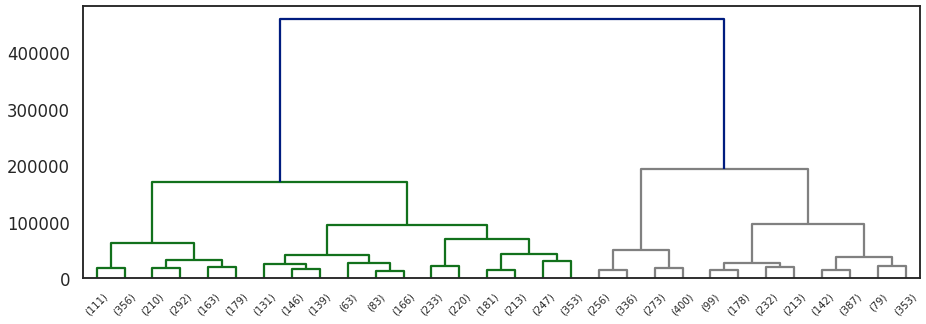

In [ ]:
from scipy.cluster import hierarchy
from matplotlib import colors

Z = hierarchy.linkage(ag.children_, method='ward')

fig, ax = plt.subplots(figsize=(15,5))

# Some color customization
dark_palette = sns.color_palette()
red = colors.to_hex(dark_palette[2])
blue = colors.to_hex(dark_palette[0])

hierarchy.set_link_color_palette([red, 'gray'])

den = hierarchy.dendrogram(Z, orientation='top',
                           p=30, truncate_mode='lastp',
                           show_leaf_counts=True, ax=ax,
                           above_threshold_color=blue)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit


y = (xg['Unemployment'] > 7).astype(int)
X_with_kmeans = xg.drop(['agglom', 'Holiday_Flag', 'Unemployment'], axis=1)
X_without_kmeans = X_with_kmeans.drop('kmeans', axis=1)
sss = StratifiedShuffleSplit(n_splits=10, random_state=6532)


def get_avg_roc_10splits(estimator, X, y):
    roc_auc_list = []
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        estimator.fit(X_train, y_train)
        y_predicted = estimator.predict(X_test)
        y_scored = estimator.predict_proba(X_test)[:, 1]
        roc_auc_list.append(roc_auc_score(y_test, y_scored))
    return np.mean(roc_auc_list)
# return classification_report(y_test, y_predicted)


estimator = RandomForestClassifier()
roc_with_kmeans = get_avg_roc_10splits(estimator, X_with_kmeans, y)
roc_without_kmeans = get_avg_roc_10splits(estimator, X_without_kmeans, y)
print("Without kmeans cluster as input to Random Forest, roc-auc is \"{0}\"".format(roc_without_kmeans))
print("Using kmeans cluster as input to Random Forest, roc-auc is \"{0}\"".format(roc_with_kmeans))


Without kmeans cluster as input to Random Forest, roc-auc is "0.9994285576505761"
Using kmeans cluster as input to Random Forest, roc-auc is "0.9992308434199739"


##Pipeline

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
filepath = '/content/drive/My Drive/Colab Notebooks/Dataset/Walmart.csv'
xg = pd.read_csv(filepath)

In [ ]:
xg

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


In [ ]:
xg = xg.drop('Date',axis=1)

In [ ]:
for col in xg.columns:
    xg[col] = xg[col].astype(np.float)

<ipython-input-56-6dbce3b12efe>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xg[col] = xg[col].astype(np.float)


In [ ]:
xg_orig = xg.copy()

In [ ]:
corr_mat = xg.corr()

# Strip the diagonal for future examination
for x in range(corr_mat.shape[0]):
    corr_mat.iloc[x,x] = 0.0

corr_mat

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Store,0.000000e+00,-0.335332,-4.386841e-16,-0.022659,0.060023,-0.209492,0.223531
Weekly_Sales,-3.353320e-01,0.000000,3.689097e-02,-0.063810,0.009464,-0.072634,-0.106176
Holiday_Flag,-4.386841e-16,0.036891,0.000000e+00,-0.155091,-0.078347,-0.002162,0.010960
Temperature,-2.265908e-02,-0.063810,-1.550913e-01,0.000000,0.144982,0.176888,0.101158
Fuel_Price,6.002295e-02,0.009464,-7.834652e-02,0.144982,0.000000,-0.170642,-0.034684
CPI,-2.094919e-01,-0.072634,-2.162091e-03,0.176888,-0.170642,0.000000,-0.302020
Unemployment,2.235313e-01,-0.106176,1.096028e-02,0.101158,-0.034684,-0.302020,0.000000


In [ ]:
corr_mat.abs().idxmax()

Store           Weekly_Sales
Weekly_Sales           Store
Holiday_Flag     Temperature
Temperature              CPI
Fuel_Price               CPI
CPI             Unemployment
Unemployment             CPI
dtype: object

In [ ]:
log_columns = xg.skew().sort_values(ascending=False)
log_columns = log_columns.loc[log_columns > 0.75]

log_columns

Holiday_Flag    3.373499
Unemployment    1.188144
dtype: float64

In [ ]:
for col in log_columns.index:
    xg[col] = np.log1p(xg[col])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()

for col in xg.columns:
    xg[col] = mms.fit_transform(xg[[col]]).squeeze()

In [ ]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

# The custom NumPy log transformer
log_transformer = FunctionTransformer(np.log1p)

# The pipeline
estimators = [('log1p', log_transformer), ('minmaxscale', MinMaxScaler())]
pipeline = Pipeline(estimators)

# Convert the original data
xg_pipe = pipeline.fit_transform(xg_orig)

In [ ]:
np.allclose(xg_pipe, xg)

False

In [ ]:
from sklearn.decomposition import PCA

pca_list = list()
feature_weight_list = list()

# Fit a range of PCA models

for n in range(1, 6):

    # Create and fit the model
    PCAmod = PCA(n_components=n)
    PCAmod.fit(xg)

    # Store the model and variance
    pca_list.append(pd.Series({'n':n, 'model':PCAmod,
                               'var': PCAmod.explained_variance_ratio_.sum()}))

    # Calculate and store feature importances
    abs_feature_values = np.abs(PCAmod.components_).sum(axis=0)
    feature_weight_list.append(pd.DataFrame({'n':n,
                                             'features': xg.columns,
                                             'values':abs_feature_values/abs_feature_values.sum()}))

pca_df = pd.concat(pca_list, axis=1).T.set_index('n')
pca_df

,model,var
n,,
1,PCA(n_components=1),0.37273
2,PCA(n_components=2),0.563031
3,PCA(n_components=3),0.717861
4,PCA(n_components=4),0.832671
5,PCA(n_components=5),0.90656


In [ ]:
features_df = (pd.concat(feature_weight_list)
               .pivot(index='n', columns='features', values='values'))

features_df

features,CPI,Fuel_Price,Holiday_Flag,Store,Temperature,Unemployment,Weekly_Sales
n,,,,,,,
1,0.577673,0.080874,0.001512,0.196542,0.050184,0.088784,0.004432
2,0.372387,0.047145,0.012918,0.364854,0.045827,0.075438,0.081430
3,0.252680,0.101460,0.193040,0.257552,0.079229,0.057383,0.058657
4,0.201596,0.209181,0.201394,0.193538,0.085942,0.063331,0.045017
5,0.160937,0.175849,0.173813,0.168016,0.153904,0.123667,0.043813


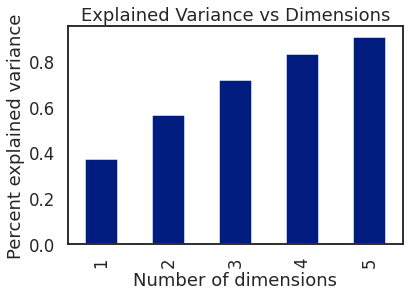

In [ ]:
sns.set_context('talk')

ax = pca_df['var'].plot(kind='bar')

ax.set(xlabel='Number of dimensions',
       ylabel='Percent explained variance',
       title='Explained Variance vs Dimensions');

This graph is the variance vs dimensions. As seen above, it is increasing consistently.

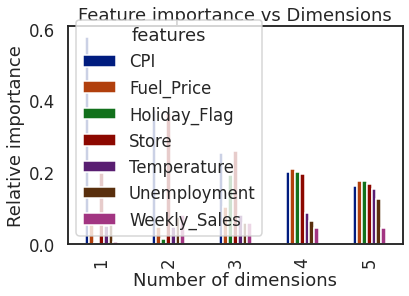

In [ ]:
ax = features_df.plot(kind='bar')

ax.set(xlabel='Number of dimensions',
       ylabel='Relative importance',
       title='Feature importance vs Dimensions');

This graph shows the features as well as the number of dimensions vs the importance of the features with the features having different colors for the legends of the graph.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler


X = xg.drop('Holiday_Flag', axis=1)
y = xg.Holiday_Flag
sss = StratifiedShuffleSplit(n_splits=10, random_state=42)

def get_avg_score(n):
    pipe = [
        ('scaler', MinMaxScaler()),
        ('pca', PCA(n_components=n)),
        ('estimator', LogisticRegression())
    ]
    pipe = Pipeline(pipe)
    scores = []
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
        pipe.fit(X_train, y_train)
        scores.append(accuracy_score(y_test, pipe.predict(X_test)))
    return np.mean(scores)


ns = [1,2,3,4,5]
score_list = [get_avg_score(n) for n in ns]

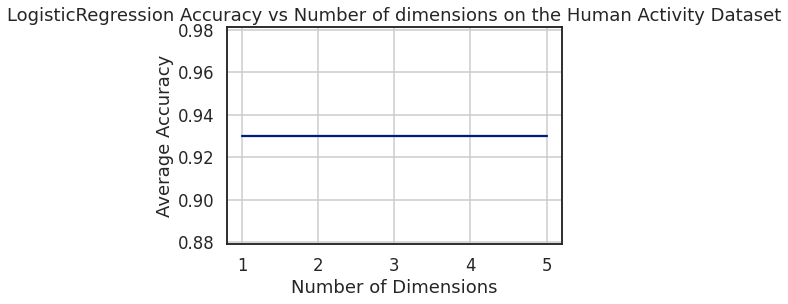

In [ ]:
sns.set_context('talk')

ax = plt.axes()
ax.plot(ns, score_list)
ax.set(xlabel='Number of Dimensions',
       ylabel='Average Accuracy',
       title='LogisticRegression Accuracy vs Number of dimensions on the Human Activity Dataset')
ax.grid(True)

The graph shows the average accuracy of our data vs the number of dimensions.

In [ ]:
xg.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,0.0,0.397291,0.0,0.434149,0.050100,0.840500,0.545562
1,0.0,0.396811,1.0,0.396967,0.038076,0.841941,0.545562
2,0.0,0.388501,0.0,0.410861,0.021042,0.842405,0.545562
3,0.0,0.332458,0.0,0.476419,0.044589,0.842707,0.545562
4,0.0,0.372661,0.0,0.475147,0.076653,0.843008,0.545562
